In [1]:
import pandas as pd
import requests
import time
import numpy as np
import seaborn as sns

In [2]:
source_df = pd.read_csv('housing.csv')

In [3]:
source_df.columns

Index(['id', 'region', 'region_url', 'price', 'type', 'sqfeet', 'Built_year',
       'beds', 'baths', 'cats_allowed', 'dogs_allowed', 'smoking_allowed',
       'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished',
       'laundry_options', 'parking_options', 'lat', 'long', 'state'],
      dtype='object')

In [4]:
coordinates = source_df[["lat","long"]].apply(list, axis=1).to_list()

In [5]:
# Function to get dict of address through an API request
def get_address(query):
    api_url = f"https://geocode.maps.co/reverse?{query}"
    resp = requests.get(api_url)
    if resp.status_code == 200:
        return resp.json()['address']
    else:
        return {}

In [6]:
data_list = []
params = ['city', 'county', 'state', 'postcode']

start = time.time()

query_list = list({f"lat={location[0]}&lon={location[1]}" for location in coordinates})

count = len(query_list)

for index, query in enumerate(query_list[:1500]):    
    try:
        row_data = []
        split_list = query.split('&')
        row_data.extend([split_list[0].split('=')[1], split_list[1].split('=')[1]])
        print(f"processing {index+1}/{count}", end = "\r")
        
        # Calling get_address function to get data using api
        address = get_address(query)
        
        for param in params:
            if param in address:
                row_data.append(address[param])
            else:
                row_data.append(None)
        # Appending the list of rwo data to a list
        data_list.append(row_data)
    except Exception as err:
        print(err)
        print(address)
        continue

end = time.time()
print(f'Total time: {end - start} seconds')
df = pd.DataFrame(data_list, columns=['lat', 'long', 'city', 'county', 'state', 'zipcode'])

# Storing the collected api data in a CSV to re-use
df.to_csv('locations.csv')

Total time: 649.8427000045776 seconds


In [7]:
df = pd.read_csv('locations.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42232 entries, 0 to 42231
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   lat      42231 non-null  float64
 1   long     42231 non-null  float64
 2   city     23123 non-null  object 
 3   county   40854 non-null  object 
 4   state    42229 non-null  object 
 5   zipcode  40731 non-null  object 
dtypes: float64(2), object(4)
memory usage: 1.9+ MB


## Step 1. Handling None values in zipcode

Lets replace None values with NaN

In [9]:
df.fillna(value=np.nan, inplace=True)

## Step 2. Finding the missing values and filling

Lets check for missing values and fill it with median of Population data

In [10]:
df.isnull().sum()

lat            1
long           1
city       19109
county      1378
state          3
zipcode     1501
dtype: int64

Lets fill the missing zipcodes with 00000

In [11]:
df['zipcode'].fillna('00000', inplace=True)

In [12]:
df.isnull().sum()

lat            1
long           1
city       19109
county      1378
state          3
zipcode        0
dtype: int64

lets fill NaN values in city, county and state with empty string

In [13]:
df.fillna('', inplace=True)

In [14]:
df.isnull().sum()

lat        0
long       0
city       0
county     0
state      0
zipcode    0
dtype: int64

## Step 3. Converting zipcode from str to int

In [15]:
# Replace charecters with empty str
df['zipcode'] = df['zipcode'].str.replace(r"[a-zA-Z`\s:]","", regex=True)
df['zipcode'] = df['zipcode'].str.replace(r"\-.*$","", regex=True)

# Replace empty str with 0
df['zipcode'] = df['zipcode'].str.replace('', '0')

# Truncate to only first 5 charecters
df['zipcode'] = df['zipcode'].str[:5]
print(df.isnull().sum())

# Filling null values with 0
df['zipcode'].fillna('0', inplace=True)

print("Null values counts after filling")
print(df.isnull().sum())

# Converting str to int
df['zipcode'] = df['zipcode'].astype(int)


lat           0
long          0
city          0
county        0
state         0
zipcode    1501
dtype: int64
Null values counts after filling
lat        0
long       0
city       0
county     0
state      0
zipcode    0
dtype: int64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42232 entries, 0 to 42231
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lat      42232 non-null  object
 1   long     42232 non-null  object
 2   city     42232 non-null  object
 3   county   42232 non-null  object
 4   state    42232 non-null  object
 5   zipcode  42232 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 1.9+ MB


## Step 4. Checking duplicates

Now let's check for duplicate rows and remove them.

In [17]:
df.duplicated().sum()

0

No duplicates found

## Step 5. Checking for Outliers

<AxesSubplot:xlabel='zipcode'>

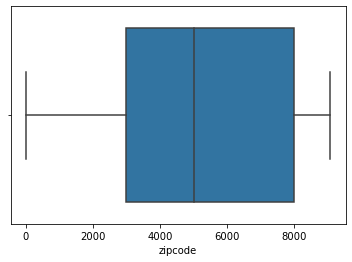

In [18]:
import seaborn as sns

sns.boxplot(x=df['zipcode'])

This data doesn't contain outliers